In [1]:
%matplotlib inline
import numpy as np
from pylab import *
from astropy import units, constants

In [2]:

def mag_to_flambda(ABmag, leff=1.55 * units.micron):
    
    fnu = 10**(-0.4 * (ABmag + 48.6)) * units.erg/units.s/units.cm**2/units.Hz
    flam = fnu * constants.c / leff**2
    
    return flam.to(units.erg/units.cm**2/units.s/units.angstrom)

In [3]:
r=mag_to_flambda(24)

In [4]:
skymag = "skymag"; objmag = "objmag" ; Dtel = "Dtel" ; texp = "texp" ; skysublimit = "skysublimit" ; BW = "BW"
lam = "lam" ; RN = "RN" ; Nexp = "Nexp" ; Efficiency = "Efficiency"
m = units.meter ; s = units.second ; percent=.01 ; AA = units.angstrom ; µm = units.micron

In [5]:
def compute_snr(system, loud=True):
    """                                 signal
       Gives SNR = --------------------------------------------------------------
                    sqrt(signal + background + rn**2) + skysublimit*background """
    
    skyfl = mag_to_flambda(system[skymag])
    objfl = mag_to_flambda(system[objmag])

    
    if loud: print("Object: %s   Sky: %s" % (objfl, skyfl))
    r = objfl/skyfl
    if loud: print("Obj/sky %3.3f" % r)
    
    Atel = np.pi * (system[Dtel]/2)**2
    t = system[texp]
    lim = system[skysublimit]
    bw = system[BW]
    ll = system[lam]
    epp = constants.h * constants.c/ll
    rn = system[RN]
    nexp = system[Nexp]
    eta = system[Efficiency]
    
    
    numsky = (skyfl / epp * bw * t * Atel).cgs * nexp * eta
    numobj = (objfl / epp * bw * t * Atel).cgs * nexp * eta
    
    
    SNR = numobj / (np.sqrt(numsky + numobj + rn**2 * nexp + (lim * numsky)**2))
    
    if loud: print("Number obj photons: %3.0f, Number sky photons: %3.0f, %%%1.3f: %3.0f" % (numobj, numsky,
                                                                                            lim, lim*numsky))
    if loud: print("RN: %3.1f" % rn)

    return SNR

In [6]:
system = {skymag: 20, objmag: 22, Dtel: 6.5*m, texp: 180*s, skysublimit: .1*percent, BW: 1*AA, lam: 1.65*µm,
         RN: 5, Nexp: 30, Efficiency: .25}


compute_snr(system)

Object: 7.18054331927879e-19 erg / (Angstrom cm2 s)   Sky: 4.530616544657145e-18 erg / (Angstrom cm2 s)
Obj/sky 0.158
Number obj photons: 267, Number sky photons: 1686, %0.001:   2
RN: 5.0


<Quantity 5.13643717>

In [7]:


def compute_systems(baseline, vary=Dtel, by=[6.5*m, 10.0*m]):
    
    SNRs = []
    for i in range(len(by)):
        system = baseline.copy()
        system[vary] = by[i]
        SNRs.append(compute_snr(system, loud=False))
        
    return SNRs

1200.0


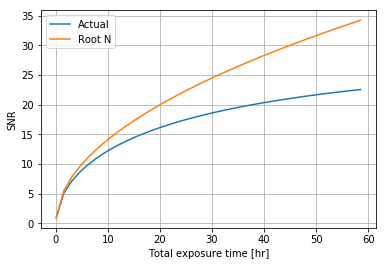

In [8]:


system = {skymag: 20, objmag: 22, Dtel: 6.5*m, texp: 180*s, skysublimit: .5*percent, BW: 1*AA, lam: 1.65*µm,
         RN: 5, Nexp: 30, Efficiency: .25}



# long exposure is 10 days or 60 hour
# 60*60 / 3 expoures

et = system[texp]
goal = 60 * units.hour
print((goal/et).cgs)

night = 6 * 60 # 6 hour
npernight = night/3
nexps = np.arange(1, 1200, 30)
snrs = compute_systems(system, vary=Nexp, by=nexps)



ets = (et * nexps).to(units.hour)
plot(ets, snrs)
plot(ets, np.sqrt(nexps))
xlabel("Total exposure time [hr]")
ylabel("SNR")
grid(True)

legend(["Actual", "Root N"])

# By Telescope diameter

Object: 7.18054331927879e-19 erg / (Angstrom cm2 s)   Sky: 2.858625783874882e-17 erg / (Angstrom cm2 s)
Obj/sky 0.025
Number obj photons: 177, Number sky photons: 7049, %0.000:   0
RN: 0.0


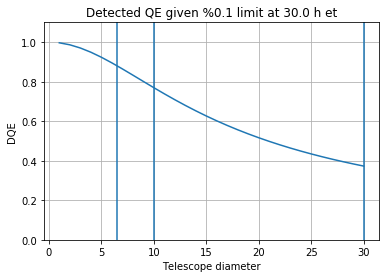

In [9]:


system = {skymag: 18, objmag: 22, Dtel: 6.5*m, texp: 180*s, skysublimit: 0.1*percent, BW: 1*AA, lam: 1.65*µm,
         RN: 0, Nexp: 600, Efficiency: .35}

dtels = np.arange(1,31,1) * units.meter

clean = system.copy()
clean[skysublimit] = 0
clean[Dtel] = dtels[0]
baseline = compute_snr(clean)


snrs = compute_systems(system, vary=Dtel, by=dtels)

total = system[Nexp] * system[texp]
lim = system[skysublimit]


plot(dtels, snrs/baseline/dtels*dtels[0])
axvline(6.5)
axvline(10)
axvline(30)
xlabel("Telescope diameter")
ylabel("DQE")
ylim(0,1.1)

grid(True)
title("Detected QE given %%%1.1f limit at %s et" % (lim*100, total.to(units.hour)))

## By sky subtraction limit

Object: 7.18054331927879e-19 erg / (Angstrom cm2 s)   Sky: 2.858625783874882e-17 erg / (Angstrom cm2 s)
Obj/sky 0.025
Number obj photons: 53121, Number sky photons: 2114791, %0.000: 211
RN: 5.0


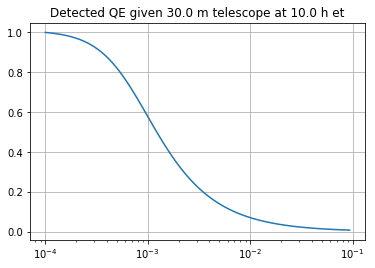

In [13]:


system = {skymag: 18, objmag: 22, Dtel: 30*m, texp: 180*s, skysublimit: 0.5*percent, BW: 1*AA, lam: 1.65*µm,
         RN: 5, Nexp: 200, Efficiency: .35}

skysublimits = 10**(np.arange(-4,-1,.03))

clean = system.copy()
clean[skysublimit] = skysublimits[0]
baseline = compute_snr(clean)
total = system[Nexp] * system[texp]


snrs = compute_systems(system, vary=skysublimit, by=skysublimits)

total = system[Nexp] * system[texp]


semilogx(skysublimits, snrs/baseline)


grid(True)
title("Detected QE given %s telescope at %s et" % (system[Dtel], total.to(units.hour)))